In [272]:
import numpy as np
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt

# 1. Zaklady

In [273]:
fs, s = wavfile.read('../audio/xzmitk01.wav')
s_count = len(s)
s_len = len(s) / fs
print(f"Samplerate: {fs}")
print(f"Number of samples: {s_count}")
print(f"Length: {s_len}s")
print(f"Minimal sample: {min(s)}, Maximal sample: {max(s)}")

Samplerate: 16000
Number of samples: 54068
Length: 3.37925s
Minimal sample: -3101, Maximal sample: 3496


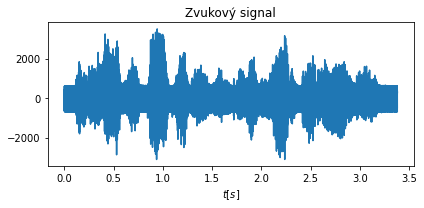

In [274]:
t = np.arange(s.size) / fs

plt.figure(figsize=(6,3))
plt.plot(t, s)
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_title('Zvukový signal')

plt.tight_layout()

# 2. Predzpracovani a ramce

In [275]:
s = s - np.mean(s)
s = s / max(s.min(), s.max(), key=abs)
n_frames = s.size // 512
frames = np.empty((1024, n_frames))
for i in range(n_frames):
    tmp = s[i * 512:(i + 2) * 512]
    frames[:len(tmp), i] = tmp[:]

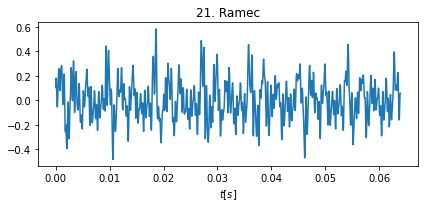

In [276]:
t = np.arange(frames[:, 21].size) / fs

plt.figure(figsize=(6,3))
plt.plot(t, frames[:, 21])
plt.gca().set_xlabel('$t[s]$')
plt.gca().set_title('21. Ramec')

plt.tight_layout()

# 3. DFT

In [277]:
def dft(arr): #https://stackoverflow.com/a/19739589
    i, j = np.meshgrid(np.arange(1024), np.arange(1024))
    omega = np.exp(-2 * np.pi * 1j / 1024)
    W = np.power(omega, i * j) / np.sqrt(1024)
    return np.dot(W, arr)

a = dft(frames[:, 21])
b = np.fft.fft(frames[:, 21])

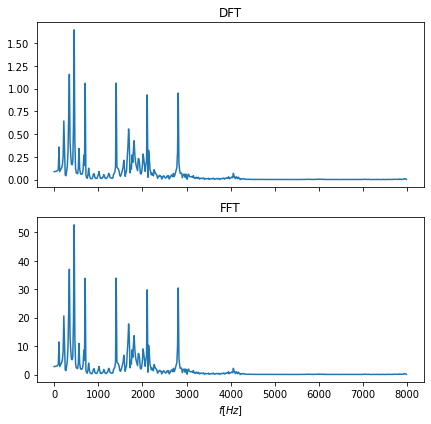

In [278]:
t1 = np.arange(a.size // 2) / a.size * fs
t2 = np.arange(b.size // 2) / b.size * fs

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex='all')

ax1.plot(t1, np.abs(a[:a.size // 2]))
ax1.set_title('DFT')

ax2.plot(t2, np.abs(b[:b.size // 2]))
ax2.set_xlabel('$f[Hz]$')
ax2.set_title('FFT')

fig.tight_layout()

# 4. Spektrogram

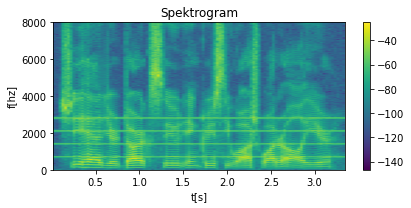

In [279]:
plt.figure(figsize=(6, 3))
plt.specgram(s, window=None, Fs=fs, NFFT=1024, noverlap=512)
plt.xlabel('t[s]')
plt.ylabel('f[hz]')
plt.title('Spektrogram')
plt.colorbar()
plt.tight_layout()

# 5. Urceni rusivych frekvenci

In [280]:
b = np.fft.fft(frames[:, 0])
peaks, _ = signal.find_peaks(np.abs(b[:b.size // 2]), prominence=1)
peaks = peaks / b.size * fs
print(peaks)
print(peaks / peaks[0])

[ 703.12 1406.25 2109.38 2812.5 ]
[1. 2. 3. 4.]


# 6. Generovani signalu

In [281]:
samples = np.arange(s.size) / fs
cos = np.zeros(s.size, dtype=np.float16)
for i in range(4):
    cos += np.cos(2 * np.pi * peaks[i] * samples)

cos = cos / max(cos.min(), cos.max(), key=abs) * np.iinfo(np.int16).max
cos = np.asarray(cos, dtype=np.int16)

wavfile.write('../audio/4cos.wav', fs, cos)

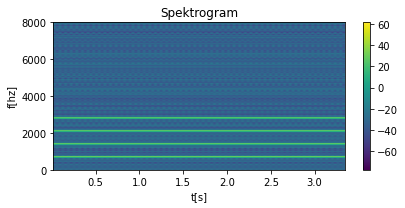

In [282]:
plt.figure(figsize=(6, 3))
plt.specgram(cos, Fs=fs, NFFT=1024, noverlap=512)
plt.xlabel('t[s]')
plt.ylabel('f[hz]')
plt.title('Spektrogram')
plt.colorbar()
plt.tight_layout()

# 7. Cistici filtr

In [283]:
N, Wn0 = signal.buttord([(peaks[0] - 50) / fs * 2, (peaks[0] + 50) / fs * 2], [(peaks[0] - 15) / fs * 2, (peaks[0] + 15) / fs * 2], 3, 40)
N, Wn1 = signal.buttord([(peaks[1] - 50) / fs * 2, (peaks[1] + 50) / fs * 2], [(peaks[1] - 15) / fs * 2, (peaks[1] + 15) / fs * 2], 3, 40)
N, Wn2 = signal.buttord([(peaks[2] - 50) / fs * 2, (peaks[2] + 50) / fs * 2], [(peaks[2] - 15) / fs * 2, (peaks[2] + 15) / fs * 2], 3, 40)
N, Wn3 = signal.buttord([(peaks[3] - 50) / fs * 2, (peaks[3] + 50) / fs * 2], [(peaks[3] - 15) / fs * 2, (peaks[3] + 15) / fs * 2], 3, 40)

b0, a0 = signal.butter(N, Wn0, 'bandstop')
b1, a1 = signal.butter(N, Wn1, 'bandstop')
b2, a2 = signal.butter(N, Wn2, 'bandstop')
b3, a3 = signal.butter(N, Wn3, 'bandstop')


In [284]:
np.set_printoptions(precision=2)
print('Coefficients:')
print(f'f0: a{a0}, b{b0}')
print(f'f1: a{a1}, b{b1}')
print(f'f2: a{a2}, b{b2}')
print(f'f3: a{a3}, b{b3}')

Coefficients:
f0: a[  1.    -7.6   25.57 -49.69  61.02 -48.47  24.33  -7.05   0.91], b[  0.95  -7.32  24.94 -49.09  61.03 -49.09  24.94  -7.32   0.95]
f1: a[  1.    -6.72  20.86 -38.68  46.76 -37.71  19.83  -6.23   0.9 ], b[  0.95  -6.48  20.34 -38.2   46.77 -38.2   20.34  -6.48   0.95]
f2: a[  1.    -5.34  14.59 -25.13  29.73 -24.5   13.87  -4.95   0.9 ], b[  0.95  -5.14  14.23 -24.82  29.73 -24.82  14.23  -5.14   0.95]
f3: a[  1.    -3.55   8.63 -13.18  15.54 -12.85   8.2   -3.29   0.9 ], b[  0.95  -3.42   8.41 -13.02  15.54 -13.02   8.41  -3.42   0.95]


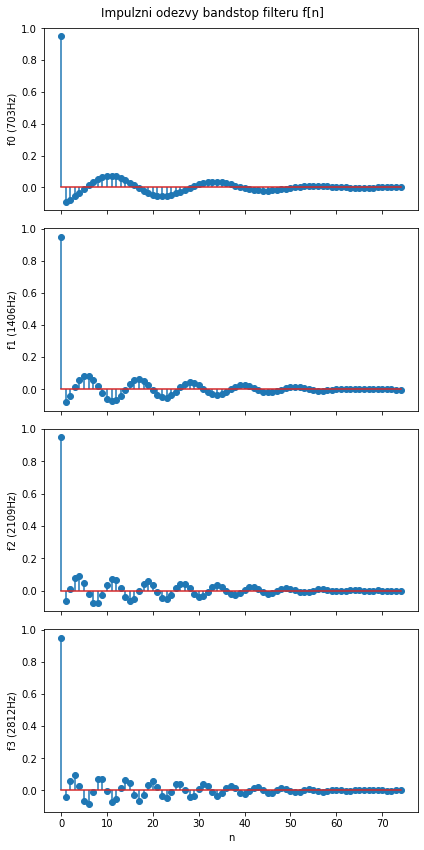

In [285]:
imp = np.zeros(75)
imp[0] = 1

f0 = signal.lfilter(b0, a0, imp)
f1 = signal.lfilter(b1, a1, imp)
f2 = signal.lfilter(b2, a2, imp)
f3 = signal.lfilter(b3, a3, imp)

fig, ax = plt.subplots(4, 1, sharex='all', figsize=(6,12))
fig.suptitle('Impulzni odezvy bandstop filteru f[n]')

ax[0].stem(np.arange(f0.size), f0)
ax[0].set_ylabel('f0 (703Hz)')
ax[1].stem(np.arange(f1.size), f1)
ax[1].set_ylabel('f1 (1406Hz)')
ax[2].stem(np.arange(f2.size), f2)
ax[2].set_ylabel('f2 (2109Hz)')
ax[3].stem(np.arange(f3.size), f3)
ax[3].set_ylabel('f3 (2812Hz)')
ax[3].set_xlabel('n')

plt.tight_layout()

# 8. Nulove body a poly

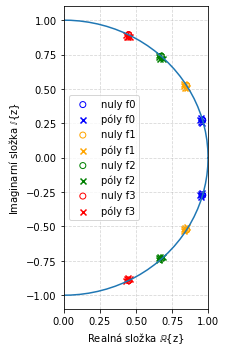

In [293]:
z0, p0, _ = signal.butter(N, Wn0, 'bandstop', output='zpk')
z1, p1, _ = signal.butter(N, Wn1, 'bandstop', output='zpk')
z2, p2, _ = signal.butter(N, Wn2, 'bandstop', output='zpk')
z3, p3, _ = signal.butter(N, Wn3, 'bandstop', output='zpk')

plt.figure(figsize=(3.2, 5))

# jednotkova kruznice
ang = np.linspace(0, 2*np.pi,100)
plt.plot(np.cos(ang), np.sin(ang))

# nuly, poly
plt.scatter(np.real(z0), np.imag(z0), marker='o', facecolors='none', edgecolors='b', label='nuly f0')
plt.scatter(np.real(p0), np.imag(p0), marker='x', color='b', label='póly f0')

plt.scatter(np.real(z1), np.imag(z1), marker='o', facecolors='none', edgecolors='orange', label='nuly f1')
plt.scatter(np.real(p1), np.imag(p1), marker='x', color='orange', label='póly f1')

plt.scatter(np.real(z2), np.imag(z2), marker='o', facecolors='none', edgecolors='g', label='nuly f2')
plt.scatter(np.real(p2), np.imag(p2), marker='x', color='g', label='póly f2')

plt.scatter(np.real(z3), np.imag(z3), marker='o', facecolors='none', edgecolors='r', label='nuly f3')
plt.scatter(np.real(p3), np.imag(p3), marker='x', color='r', label='póly f3')

plt.gca().set_xlabel('Realná složka $\mathbb{R}\{$z$\}$')
plt.gca().set_ylabel('Imaginarní složka $\mathbb{I}\{$z$\}$')

plt.grid(alpha=0.5, linestyle='--')
plt.legend(loc='center left')
plt.xlim(0, 1)

plt.tight_layout()

# 9. Frekvencni charakteristika

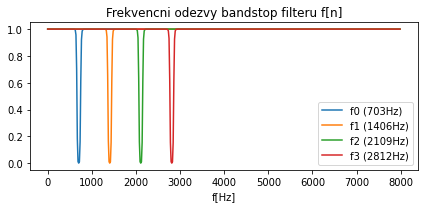

In [287]:
w0, h0 = signal.freqz(b0, a0, plot=None)
w1, h1 = signal.freqz(b1, a1, plot=None)
w2, h2 = signal.freqz(b2, a2, plot=None)
w3, h3 = signal.freqz(b3, a3, plot=None)

f = (fs / 2) * w0 / np.pi

plt.figure(figsize=(6,3))
plt.title('Frekvencni odezvy bandstop filteru f[n]')

plt.plot(f, abs(h0), label='f0 (703Hz)')
plt.plot(f, abs(h1), label='f1 (1406Hz)')
plt.plot(f, abs(h2), label='f2 (2109Hz)')
plt.plot(f, abs(h3), label='f3 (2812Hz)')
plt.xlabel('f[Hz]')
plt.legend()
plt.tight_layout()

# 10. Filtrace

In [290]:
clean = signal.lfilter(b0, a0, s)
clean = signal.lfilter(b1, a1, clean)
clean = signal.lfilter(b2, a2, clean)
clean = signal.lfilter(b3, a3, clean)
clean = clean / max(clean.min(), clean.max(), key=abs)

print(f'Min sample: {np.min(clean)}, Max sample: {np.max(clean)}')

clean *= np.iinfo(np.int16).max
clean = np.asarray(clean, dtype=np.int16)

wavfile.write('../audio/clean_bandstop.wav', fs, clean)

Min sample: -0.9665262525042227, Max sample: 1.0
